In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.ClusterDE as cd

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [4]:
importlib.reload(up)
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1326 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Attach transcription units and aggregate

In [6]:
tu = pd.read_csv("../../data/MOBA_scRNAseq/PAO1 gene ID and TU.csv")
tu

PAO1_ID  TU_ID Regulation - transcription units of gene
0     PA0001      1             gyrB // recF // dnaN // dnaA
1     PA0002      1             gyrB // recF // dnaN // dnaA
2     PA0003      1             gyrB // recF // dnaN // dnaA
3     PA0004      1             gyrB // recF // dnaN // dnaA
4     PA0005      2                           PA0006 // lptA
...      ...    ...                                      ...
5692  PA5566   3750                                   PA5566
5693  PA5567   3751                                   PA5567
5694  PA5568   3752                                   PA5568
5695  PA5569   3753                             rpmH // rnpA
5696  PA5570   3753                             rpmH // rnpA

[5697 rows x 3 columns]

In [7]:
data_maxpool.var = pd.merge(data_maxpool.var, tu, left_index=True, right_on="PAO1_ID")
data_maxpool.var.index = data_maxpool.var["PAO1_ID"]
data_maxpool.var

feature_types genome  n_cells_by_counts  mean_counts  \
PAO1_ID                                                           
PA0001   Gene Expression   PA01                579     0.855204   
PA0002   Gene Expression   PA01                450     0.668175   
PA0003   Gene Expression   PA01                675     1.220211   
PA0004   Gene Expression   PA01                370     0.500000   
PA0005   Gene Expression   PA01                155     0.175716   
...                  ...    ...                ...          ...   
PA5566   Gene Expression   PA01                 14     0.012066   
PA5567   Gene Expression   PA01                176     0.187029   
PA5568   Gene Expression   PA01                533     0.786576   
PA5569   Gene Expression   PA01               1175     5.466817   
PA5570   Gene Expression   PA01                340     0.609351   

         log1p_mean_counts  pct_dropout_by_counts  total_counts  \
PAO1_ID                                                           
PA0001            0.617994              56.334842        1134.0   
PA0002            0.511730              66.063348         886.0   
PA0003            0.797602              49.095023        1618.0   
PA0004            0.405465              72.096531         663.0   
PA0005            0.161878              88.310709         233.0   
...                    ...                    ...           ...   
PA5566            0.011994              98.944193          16.0   
PA5567            0.171453              86.726998         248.0   
PA5568            0.580301              59.803922        1043.0   
PA5569            1.866684              11.387632        7249.0   
PA5570            0.475831              74.358974         808.0   

         log1p_total_counts PAO1_ID  TU_ID  \
PAO1_ID                                      
PA0001             7.034388  PA0001      1   
PA0002             6.787845  PA0002      1   
PA0003             7.389564  PA0003      1   
PA0004             6.498282  PA0004      1   
PA0005             5.455321  PA0005      2   
...                     ...     ...    ...   
PA5566             2.833213  PA5566   3750   
PA5567             5.517453  PA5567   3751   
PA5568             6.950815  PA5568   3752   
PA5569             8.888757  PA5569   3753   
PA5570             6.695799  PA5570   3753   

        Regulation - transcription units of gene  
PAO1_ID                                           
PA0001              gyrB // recF // dnaN // dnaA  
PA0002              gyrB // recF // dnaN // dnaA  
PA0003              gyrB // recF // dnaN // dnaA  
PA0004              gyrB // recF // dnaN // dnaA  
PA0005                            PA0006 // lptA  
...                                          ...  
PA5566                                    PA5566  
PA5567                                    PA5567  
PA5568                                    PA5568  
PA5569                              rpmH // rnpA  
PA5570                              rpmH // rnpA  

[5572 rows x 11 columns]

In [8]:
importlib.reload(up)

data_maxpool.X = sps.csr_matrix(data_maxpool.X)
X_agg, agg_features = up.grouped_var_agg(data_maxpool, group_key="TU_ID", agg_fn=np.sum)

data_pool = ad.AnnData(
    X=sps.csr_matrix(X_agg),
    obs=data_maxpool.obs,
    var=pd.DataFrame(index=agg_features)
)
data_pool

Aggregating feature 100/3687
Aggregating feature 200/3687
Aggregating feature 300/3687
Aggregating feature 400/3687
Aggregating feature 500/3687
Aggregating feature 600/3687
Aggregating feature 700/3687
Aggregating feature 800/3687
Aggregating feature 900/3687
Aggregating feature 1000/3687
Aggregating feature 1100/3687
Aggregating feature 1200/3687
Aggregating feature 1300/3687
Aggregating feature 1400/3687
Aggregating feature 1500/3687
Aggregating feature 1600/3687
Aggregating feature 1700/3687
Aggregating feature 1800/3687
Aggregating feature 1900/3687
Aggregating feature 2000/3687
Aggregating feature 2100/3687
Aggregating feature 2200/3687
Aggregating feature 2300/3687
Aggregating feature 2400/3687
Aggregating feature 2500/3687
Aggregating feature 2600/3687
Aggregating feature 2700/3687
Aggregating feature 2800/3687
Aggregating feature 2900/3687
Aggregating feature 3000/3687
Aggregating feature 3100/3687
Aggregating feature 3200/3687
Aggregating feature 3300/3687
Aggregating feature

AnnData object with n_obs × n_vars = 1326 × 3687
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
print(np.sum(data_maxpool.X, axis=1) - np.sum(data_pool.X, axis=1))

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


### Filter cells

--> filter based on mean absolute standard deviation

In [10]:
importlib.reload(ut)
data_TU = ut.filter_outliers(data_pool, nmads=5, min_cells=2)
print(data_pool.obs.outlier.value_counts())
print(f"Total number of cells: {data_pool.n_obs}")
print(f"Number of cells after filtering: {data_TU.n_obs}")
data_TU

outlier
False    1255
True       71
Name: count, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 3668
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

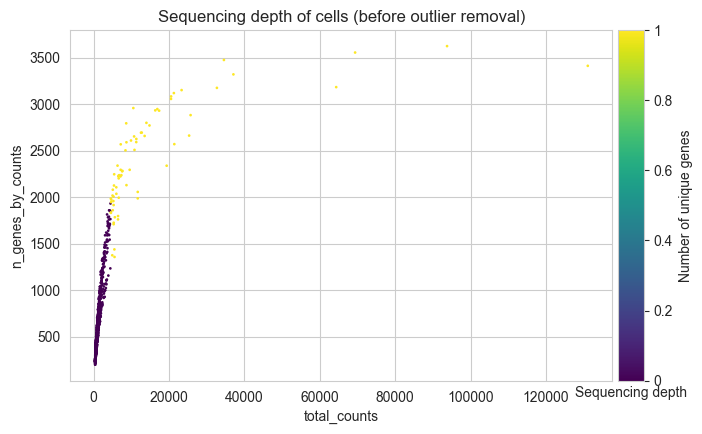

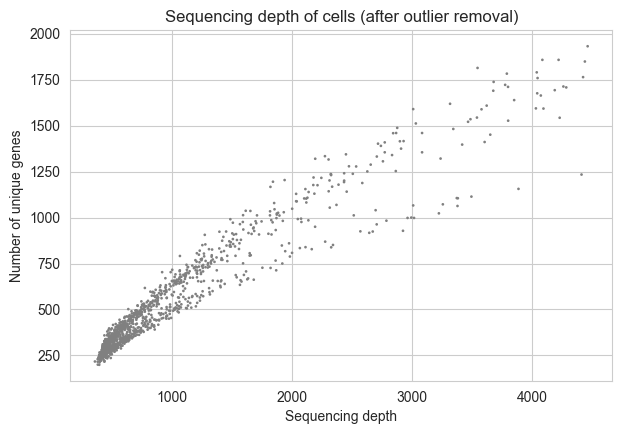

In [11]:
sc.pl.scatter(data_pool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_TU, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [12]:
data_TU.layers["counts"] = data_TU.X.copy()

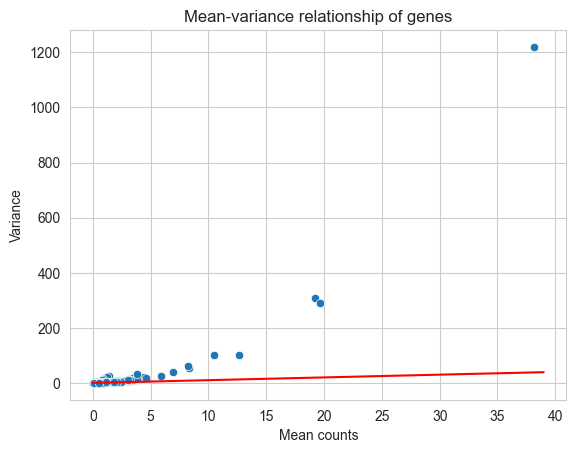

In [13]:
data_TU.var["var_counts"] = np.asarray(np.var(data_TU.X.toarray(), axis=0)).squeeze()
data_TU.var["mean_counts"] = np.asarray(np.mean(data_TU.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_TU.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_TU.var["mean_counts"]))], [0, np.ceil(np.max(data_TU.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [14]:
nb.estimate_overdisp_nb(data_TU, layer="counts", flavor="BFGS")
data_TU.var["nb_overdisp_cutoff_bfgs"] = data_TU.var["nb_overdisp_cutoff"]
data_TU.var["nb_overdisp_bfgs"] = data_TU.var["nb_overdisp"]


Fitting feature 100/3668
Fitting feature 200/3668
Fitting feature 300/3668
Fitting feature 400/3668
Fitting feature 500/3668
Fitting feature 600/3668
Fitting feature 700/3668
Fitting feature 800/3668
Fitting feature 900/3668
Fitting feature 1000/3668
Fitting feature 1100/3668
Fitting feature 1200/3668
Fitting feature 1300/3668
Fitting feature 1400/3668
Fitting feature 1500/3668
Fitting feature 1600/3668
Fitting feature 1700/3668
Fitting feature 1800/3668
Fitting feature 1900/3668
Fitting feature 2000/3668
Fitting feature 2100/3668
Fitting feature 2200/3668
Fitting feature 2300/3668
Fitting feature 2400/3668
Fitting feature 2500/3668
Fitting feature 2600/3668
Fitting feature 2700/3668
Fitting feature 2800/3668
Fitting feature 2900/3668
Fitting feature 3000/3668
Fitting feature 3100/3668
Fitting feature 3200/3668
Fitting feature 3300/3668
Fitting feature 3400/3668
Fitting feature 3500/3668
Fitting feature 3600/3668


In [15]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_TU, layer="counts")

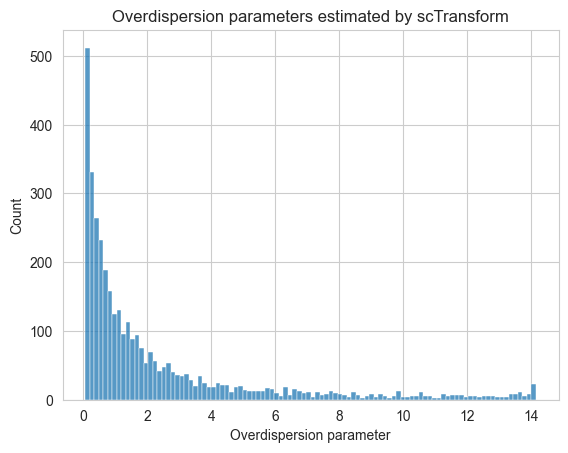

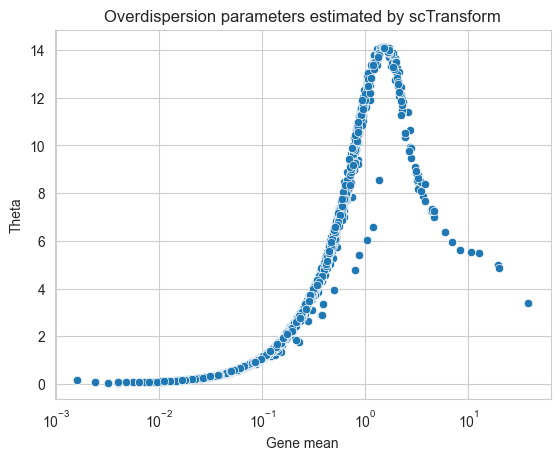

In [16]:
sns.histplot(data=data_TU.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_TU.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

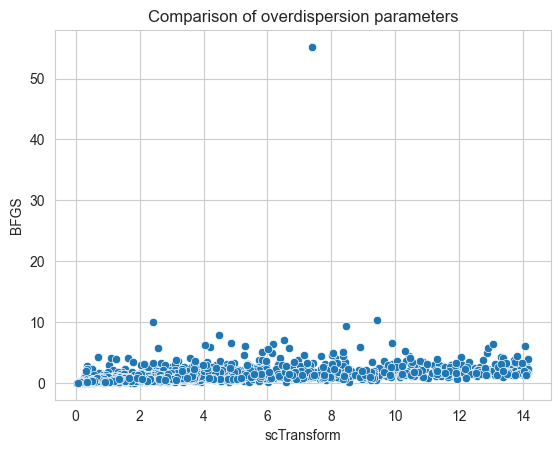

Correlation: [[1.         0.48321388]
 [0.48321388 1.        ]]


In [17]:
g = sns.scatterplot(data=data_TU.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_TU.var['nb_overdisp_cutoff_bfgs'], data_TU.var['nb_overdisp_cutoff'])}")

In [18]:
data_TU.X = data_TU.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [19]:
sc.pp.normalize_total(data_TU, target_sum=None, layer=None)
data_TU.X = sps.csr_matrix(np.log(data_TU.X.toarray() + np.array(data_TU.var["nb_overdisp_cutoff"] / 4)))
data_TU.layers["vst_counts"] = data_TU.X.copy()
sc.pp.scale(data_TU, max_value=10, zero_center=True)
# data_TU.X[np.isnan(data_TU.X)] = 0
sc.tl.pca(data_TU, svd_solver='arpack')

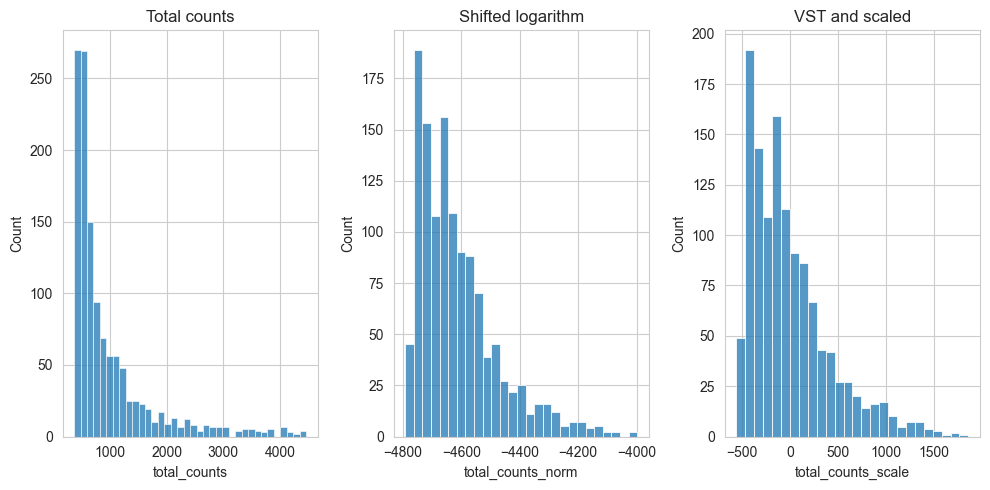

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_TU.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_TU.obs["total_counts_norm"] = data_TU.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_TU.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_TU.obs["total_counts_scale"] = data_TU.X.sum(1)
p2 = sns.histplot(data_TU.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [21]:
data_train, data_test = cs.countsplit_adata(data_TU, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=5678)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 3611
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    layers: 'counts'


In [22]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

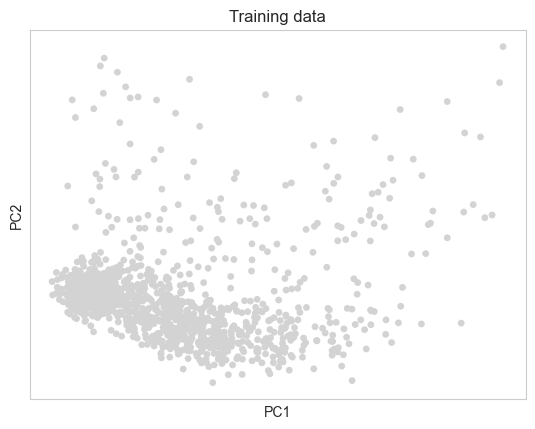

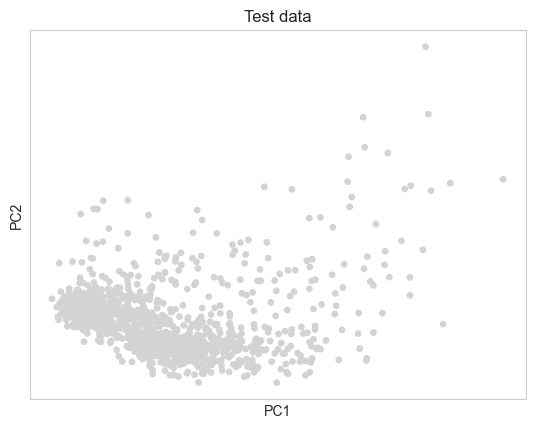

In [23]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [24]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


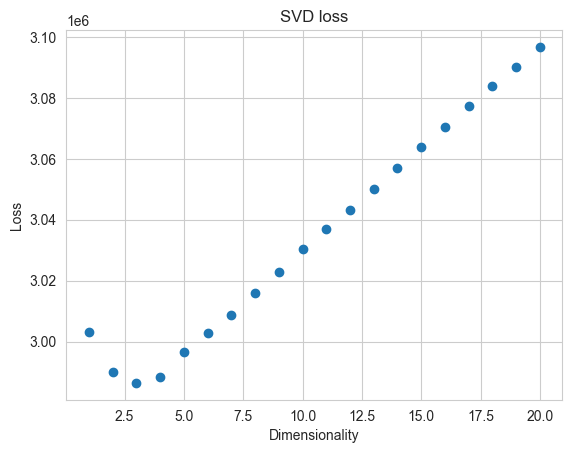

In [25]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

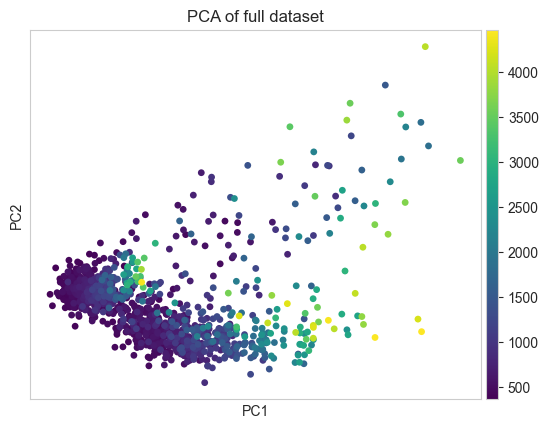

In [26]:
sc.pl.pca(data_TU, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [27]:
print(data_TU)
print(data_TU.X[:5, :5])

AnnData object with n_obs × n_vars = 1255 × 3668
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
[[ 0.09467245 -0.4284529  -0.20200354  1.21577042 -0.21367684]
 [-0.37583546 -0.4284529  -0.20200354  1.65690012 -0.21367684]
 [-1.37668606 -0.4284529  -0.20200354  1.36580244 -0.21367684]
 [ 1.98410816 -0.4284529  -0.20200354 -0.78066783 -0.21367684]
 [-1.37668606  3.20059197 -0.20200354 -0.78066783 -0.21367684]]


## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [28]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_TU, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, embedding_method="UMAP", similarity_percent=0.5, save_path="S2_TU_scdeed")

calculating (10, 0.05) - run 1/85


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 0.7) - run 30/85
calculating (40, 

Optimal number of neighbors: 100
Optimal min_dist: 0.3


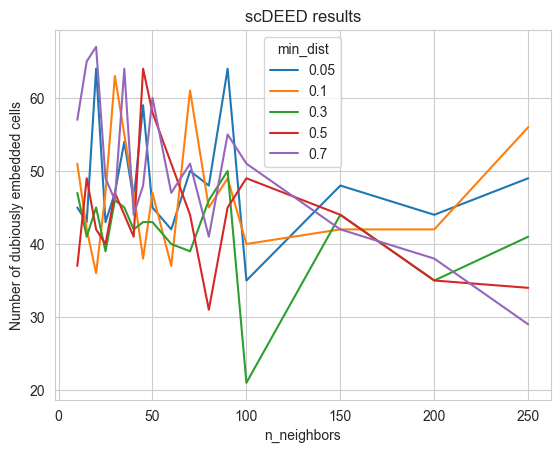

In [29]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [30]:
sc.pp.neighbors(data_TU, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_TU, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


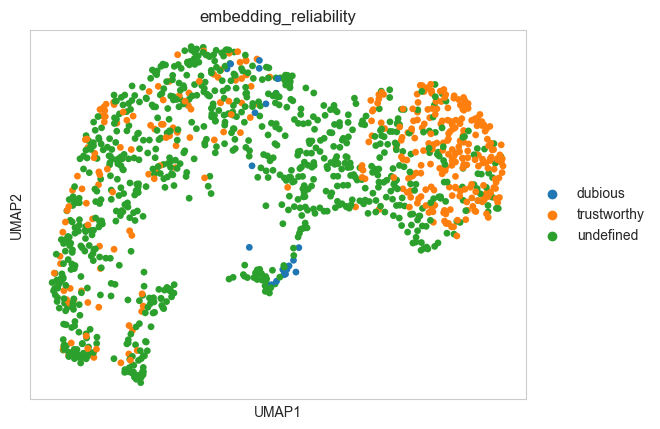

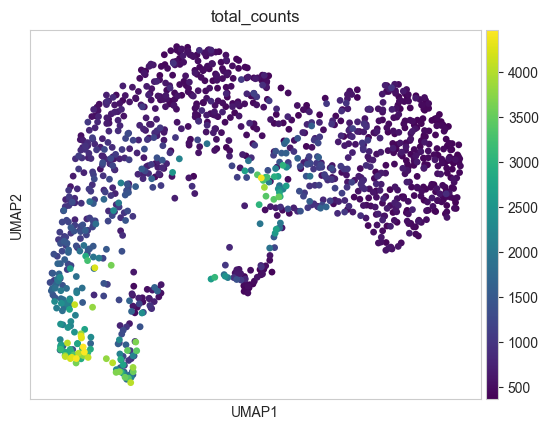

In [31]:
sc.pl.umap(data_TU, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_TU, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [32]:
data_TU.write(data_path + "/TU_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [33]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

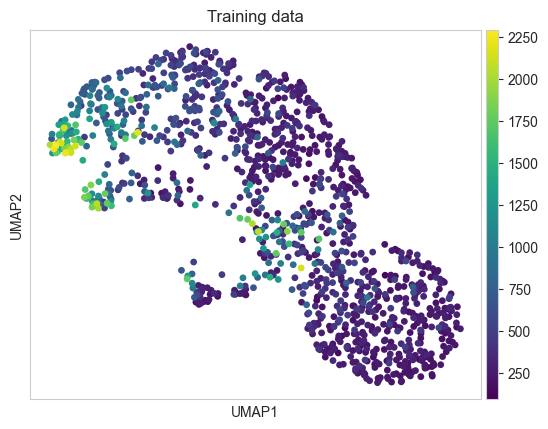

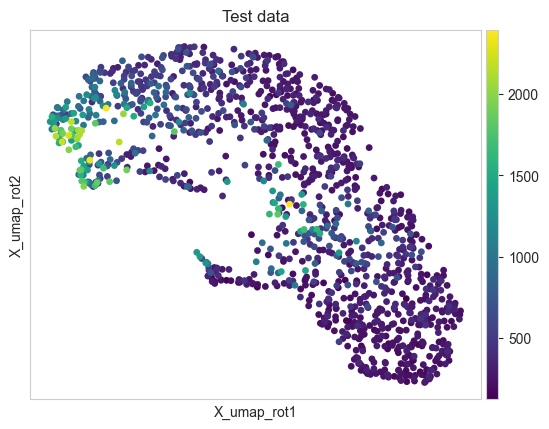

In [34]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [35]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

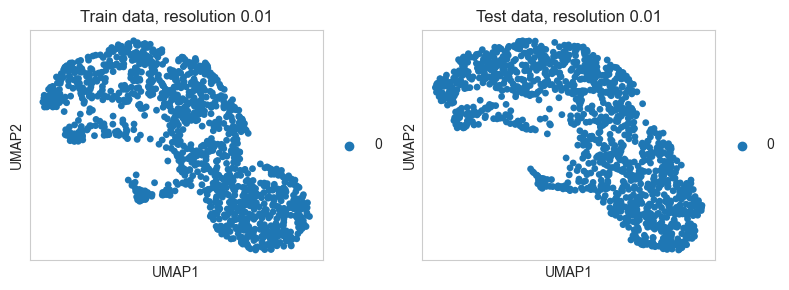

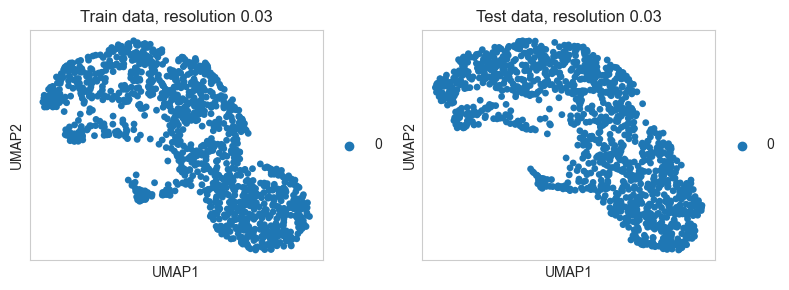

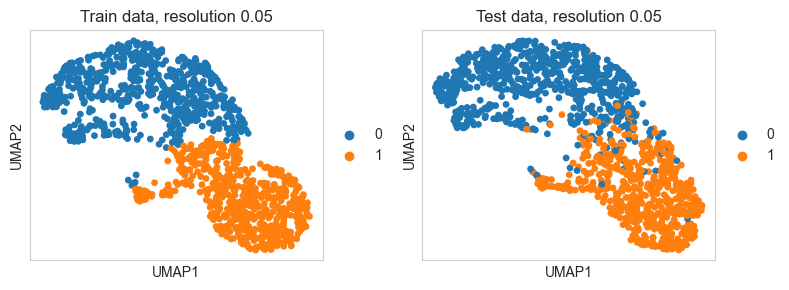

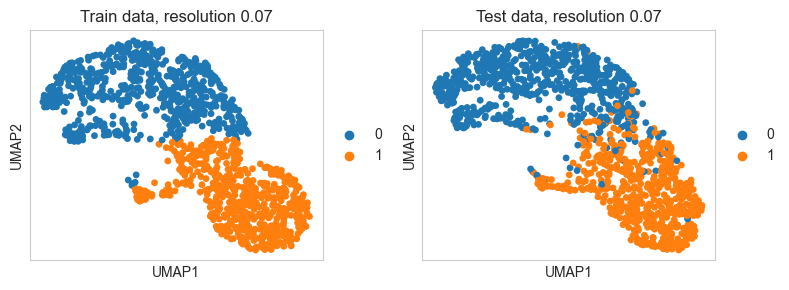

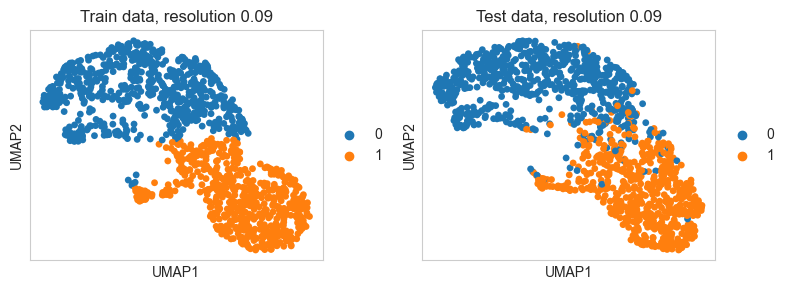

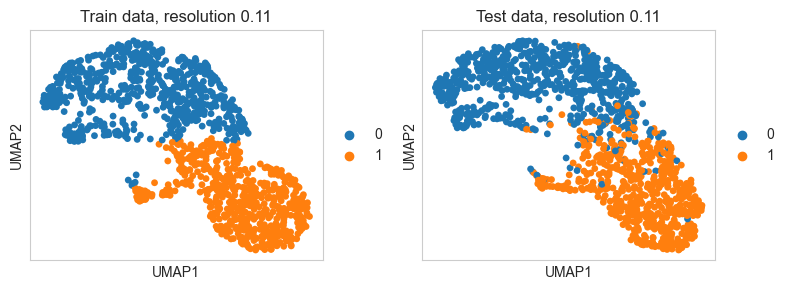

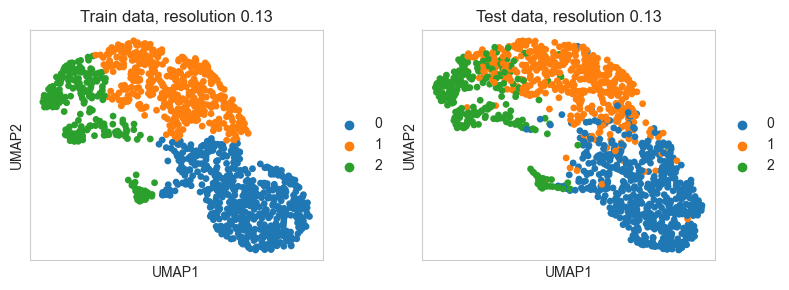

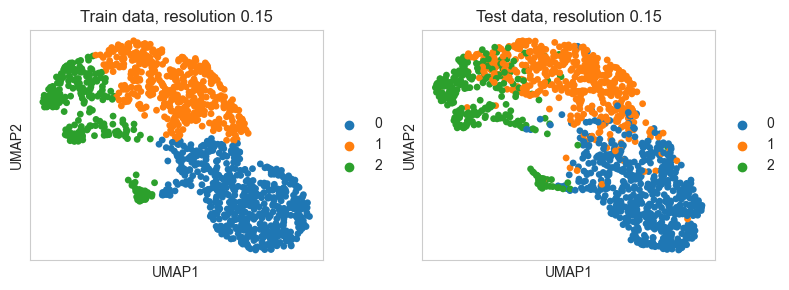

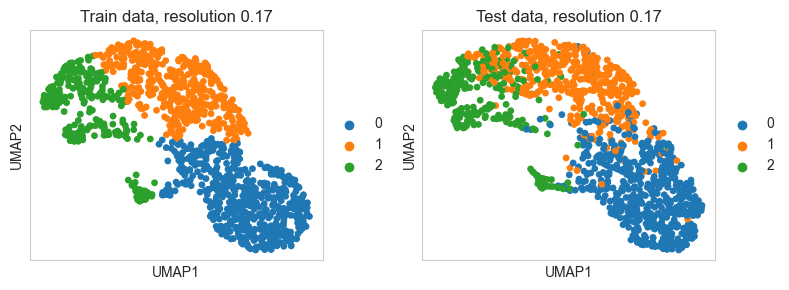

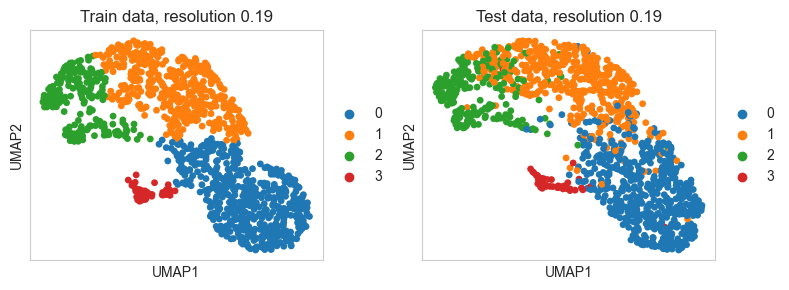

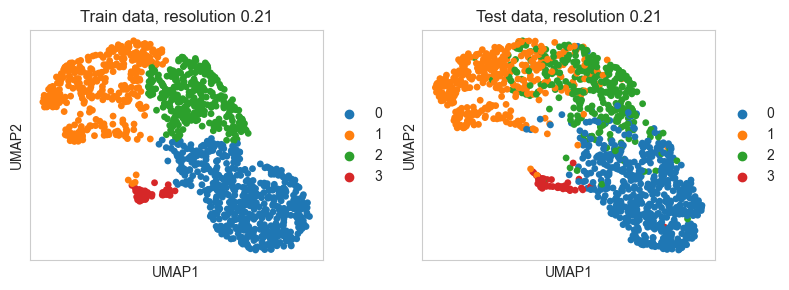

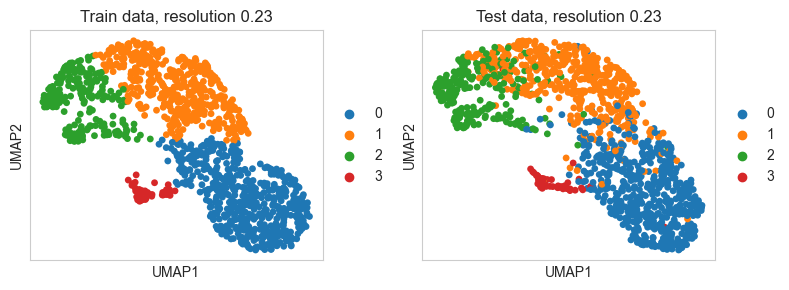

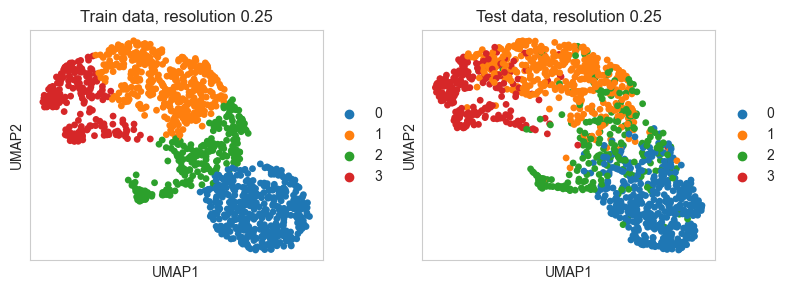

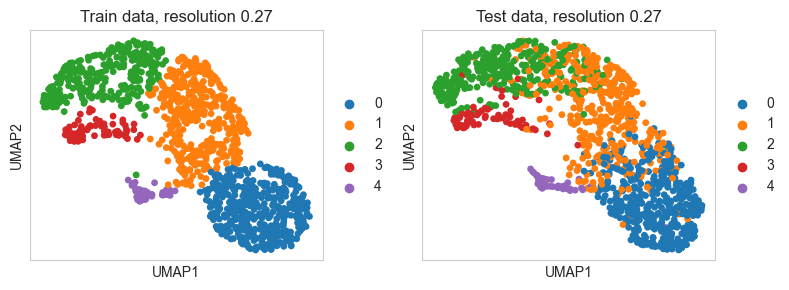

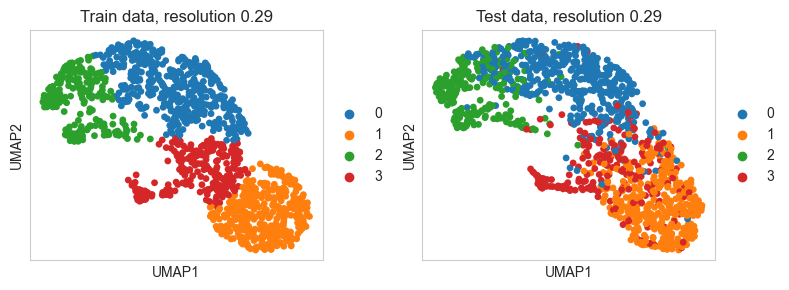

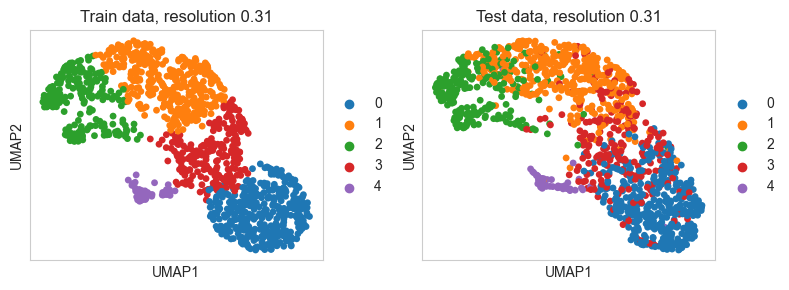

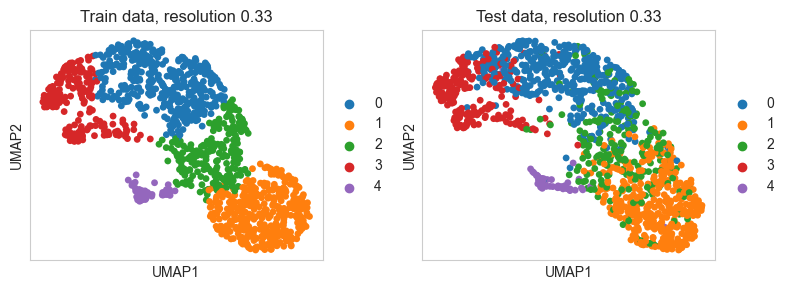

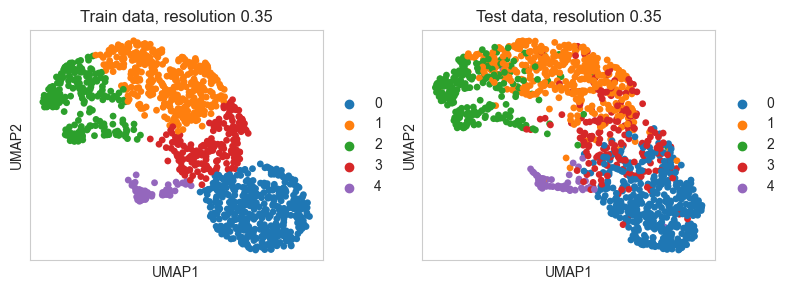

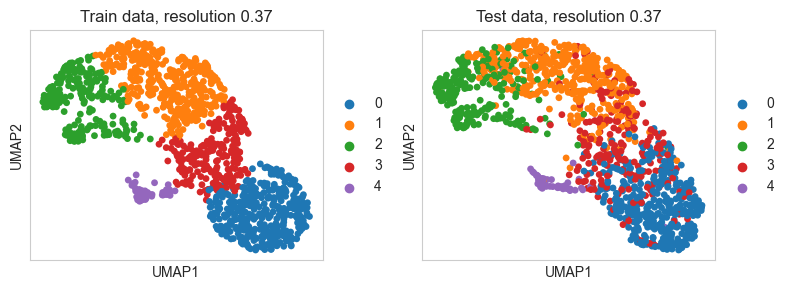

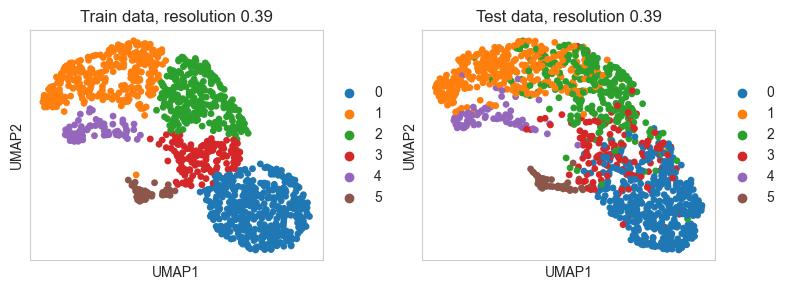

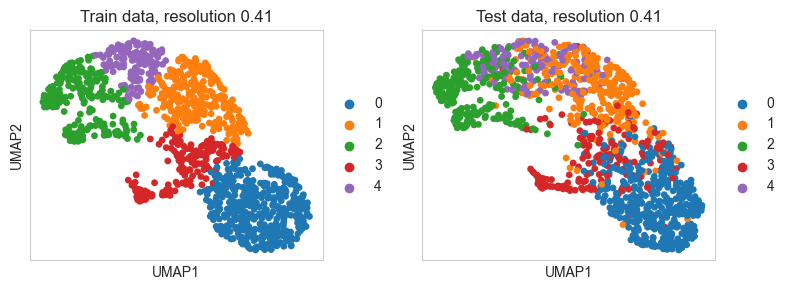

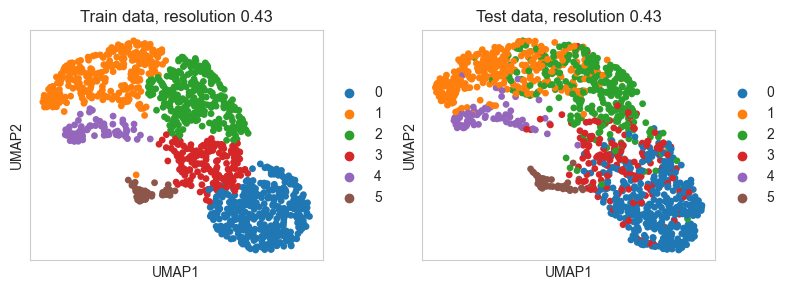

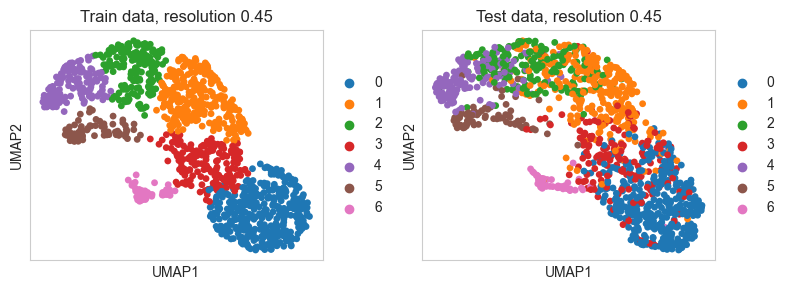

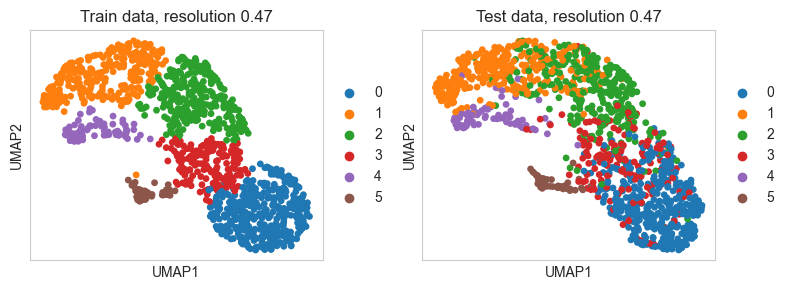

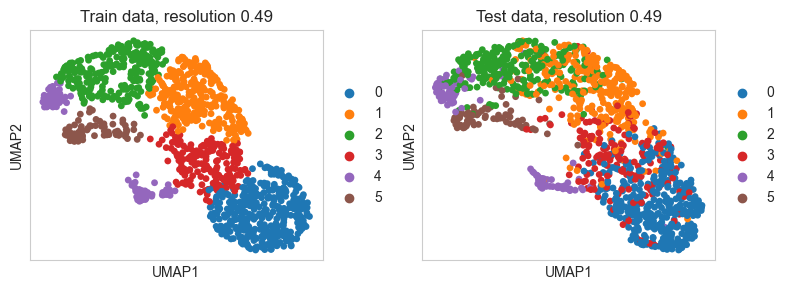

In [36]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [37]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.448 - Test: 0.43 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.439 - Test: 0.419 - Random: 0.215
resolution: 0.09 - clusters: 2 - Train: 0.429 - Test: 0.409 - Random: 0.204
resolution: 0.11 - clusters: 2 - Train: 0.418 - Test: 0.4 - Random: 0.197
resolution: 0.13 - clusters: 3 - Train: 0.395 - Test: 0.355 - Random: 0.133
resolution: 0.15 - clusters: 3 - Train: 0.388 - Test: 0.347 - Random: 0.126
resolution: 0.17 - clusters: 3 - Train: 0.381 - Test: 0.338 - Random: 0.12
resolution: 0.19 - clusters: 4 - Train: 0.371 - Test: 0.33 - Random: 0.106
resolution: 0.21 - clusters: 4 - Train: 0.366 - Test: 0.316 - Random: 0.094
resolution: 0.23 - clusters: 4 - Train: 0.357 - Test: 0.314 - Random: 0.091
resolution: 0.25 - clusters: 4 - Train: 0.349 - Test: 0.278 - Random: 0.068
resolution: 0.27 - clus

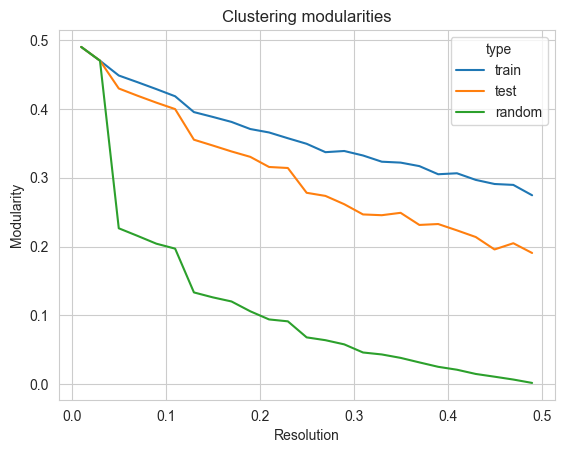

In [38]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

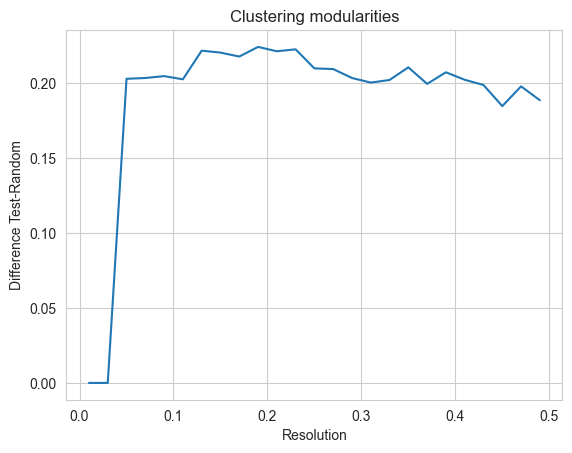

In [39]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [40]:
sc.tl.leiden(data_TU, resolution=res_opt, key_added="leiden_opt")

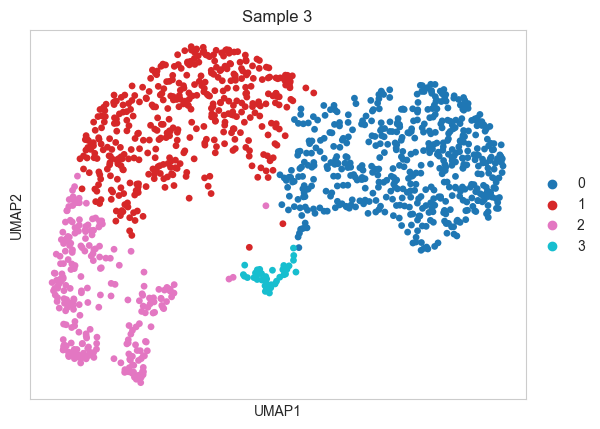

In [41]:
sc.pl.umap(data_TU, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [42]:
data_TU.write(data_path + "/TU_processed.h5ad")

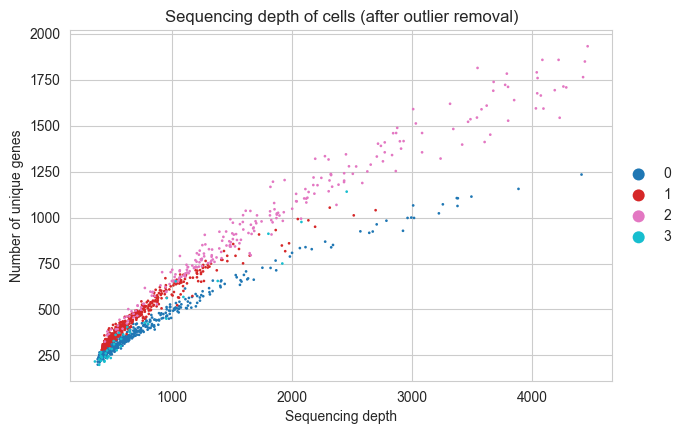

In [43]:
sc.pl.scatter(data_TU, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

In [44]:
data_TU.var_names

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '3744', '3745', '3746', '3747', '3748', '3749', '3750', '3751', '3752',
       '3753'],
      dtype='object', length=3668)

## Synthetic Null generation

In [45]:
importlib.reload(cd)
cd.construct_synthetic_null(data_TU, save_path="../../data/MOBA_scRNAseq/outs_S2/scdesign_synthetic_null_TU")



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, row

  |=======================================================| 100%, Elapsed 03:52


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 01:23


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 04:35


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:08


R[write to console]: New Data Generating End

R[write to console]: Warning:
R[write to console]:  Overwriting previous file ../../data/MOBA_scRNAseq/outs_S2/scdesign_synthetic_null_TU.h5seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA



## Differential expression

### Synthetic null processing

In [46]:
data_null = ad.AnnData()
data_TU = sc.read_h5ad(data_path + "/TU_processed.h5ad")
data_TU

AnnData object with n_obs × n_vars = 1255 × 3668
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [47]:
k_opt = 3
n_neighbors_opt = 40
min_dist_opt = 0.05
res_opt = 0.19

In [48]:
%%R -o data_null

suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(SeuratDisk))
data.null <- LoadH5Seurat("../../data/MOBA_scRNAseq/outs_S2/scdesign_synthetic_null_TU.h5Seurat")
data_null <- as.SingleCellExperiment(data.null)

data_null

class: SingleCellExperiment 
dim: 3668 1255 
metadata(0):
assays(2): counts logcounts
rownames(3668): 1 2 ... 3752 3753
rowData names(0):
colnames(1255): AAACCCATCGGTGCAC-1 AAACGCTAGGCGCTTC-1 ...
  TTTGACTTCTTTACAC-1 TTTGTTGGTAGTGGCA-1
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):


Validating h5Seurat file
Initializing RNA with data
Adding counts for RNA
Adding miscellaneous information for RNA
Adding command information
Adding cell-level metadata
Adding miscellaneous information
Adding tool-specific results


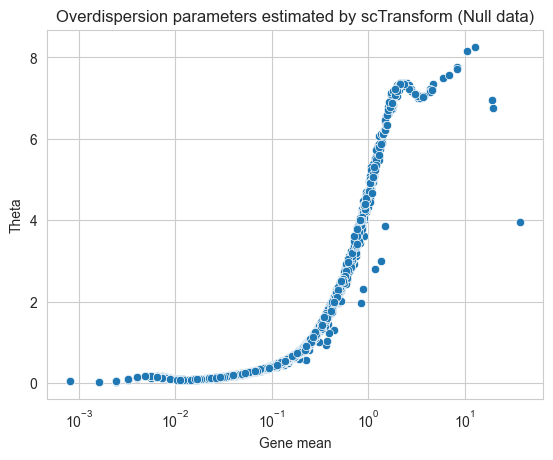

In [49]:
nb.estimate_overdisp_nb(data_null)
data_null.var["mean_counts"] = np.asarray(np.mean(data_null.X, axis=0)).squeeze()
g = sns.scatterplot(data=data_null.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform (Null data)")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

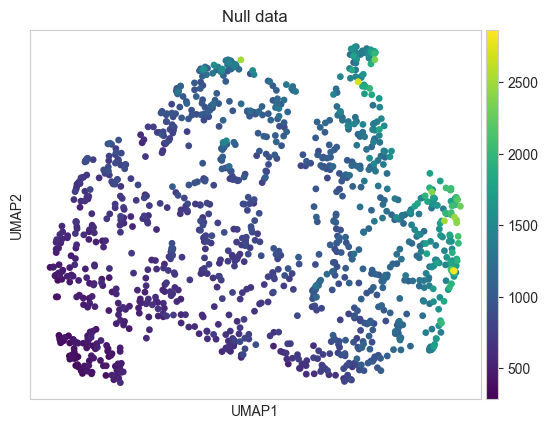

In [50]:
sc.pp.calculate_qc_metrics(data_null, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null, target_sum=None, layer=None)
data_null.X = sps.csr_matrix(np.log(data_null.X.toarray() + np.array(data_null.var["nb_overdisp_cutoff"] / 4)))
data_null.layers["vst_counts"] = data_null.X.copy()
sc.pp.scale(data_null, max_value=10, zero_center=True)
data_null.X[np.isnan(data_null.X)] = 0
sc.tl.pca(data_null, svd_solver='arpack')
sc.pp.neighbors(data_null, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

Resolution for two clusters: 0.09


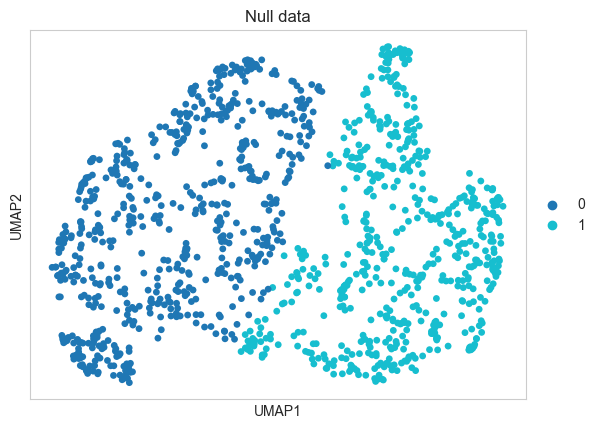

In [51]:
res2 = 0.05
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null, resolution=res2, key_added="leiden", random_state=1234)
    nclust = len(data_null.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")
sc.pl.umap(data_null, color="leiden", palette="tab10", title="Null data")
plt.show()

### Calculate differential expression

In [52]:
sc.tl.rank_genes_groups(data_null, groupby='leiden', method='wilcoxon')
p_null = pd.DataFrame({"pval_null": [x[1] for x in data_null.uns["rank_genes_groups"]["pvals"]]}, index = [x[1] for x in data_null.uns["rank_genes_groups"]["names"]])
print(p_null)

         pval_null
2744  1.115784e-72
2971  8.149471e-57
894   1.381409e-49
1042  2.402603e-45
2718  8.003691e-45
...            ...
2877  1.137729e-19
2869  1.717947e-20
2870  5.192325e-29
2866  1.422007e-29
2868  2.898725e-44

[3668 rows x 1 columns]


In [53]:
clusters = data_TU.obs["leiden_opt"].unique()
print(clusters)

['0', '1', '2', '3']
Categories (4, object): ['0', '1', '2', '3']


In [58]:
importlib.reload(cd)
DEs = {}
pvals = {}
fdr = 0.05

for c in clusters:
    data_TU.obs[f"is_cluster_{c}"] = ([x == c for x in data_TU.obs["leiden_opt"]])
    data_TU.obs[f"is_cluster_{c}"] = data_TU.obs[f"is_cluster_{c}"].astype("category")
    sc.tl.rank_genes_groups(data_TU, f'is_cluster_{c}', method='wilcoxon', key_added=f"rank_genes_groups_{c}")
    p_data = pd.DataFrame(
        {"pval_data": [x[1] for x in data_TU.uns[f"rank_genes_groups_{c}"]["pvals"]]},
        index = [x[1] for x in data_TU.uns[f"rank_genes_groups_{c}"]["names"]]
    )
    DE_TU, pval_TU = cd.call_de(p_data, p_null, FDR=fdr, correct=True)
    data_TU.var[f"pval_cluster_{c}"] = pval_TU["pval_data"]
    data_TU.var[f"q_cluster_{c}"] = pval_TU["q"]
    data_TU.var[f"DE_cluster_{c}"] = (data_TU.var[f"q_cluster_{c}"] < fdr)
    
    DEs[c] = DE_TU
    pvals[c] = pval_TU

In [59]:
data_TU.var[data_TU.var["DE_cluster_0"]].index

Index(['1', '4', '11', '14', '22', '32', '33', '40', '49', '50',
       ...
       '3710', '3712', '3713', '3730', '3732', '3733', '3746', '3747', '3749',
       '3752'],
      dtype='object', length=695)

In [60]:
DEs["0"].index.sort_values()

Index(['1', '1017', '1018', '1019', '1020', '1024', '1025', '1026', '1028',
       '1029',
       ...
       '894', '906', '907', '911', '912', '917', '924', '941', '942', '964'],
      dtype='object', length=695)

In [61]:
data_TU.write(data_path + "/TU_processed.h5ad")

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_TU = sc.read_h5ad(data_path + "/TU_processed.h5ad")

In [4]:
data_export_TU = ad.AnnData(
    X=data_TU.X.copy(),
    obs=data_TU.obs.loc[:, ["total_counts", "n_genes_by_counts", "leiden_opt"]],
    var=data_TU.var.loc[:, ["total_counts", "n_cells_by_counts", "nb_overdisp_cutoff"]],
    uns={k: data_TU.uns[k] for k in ["leiden", "leiden_opt_colors", "neighbors", "pca", "umap"]},
    obsm=data_TU.obsm,
    varm=data_TU.varm,
    obsp=data_TU.obsp
)
data_export_TU

AnnData object with n_obs × n_vars = 1255 × 3668
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'nb_overdisp_cutoff'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

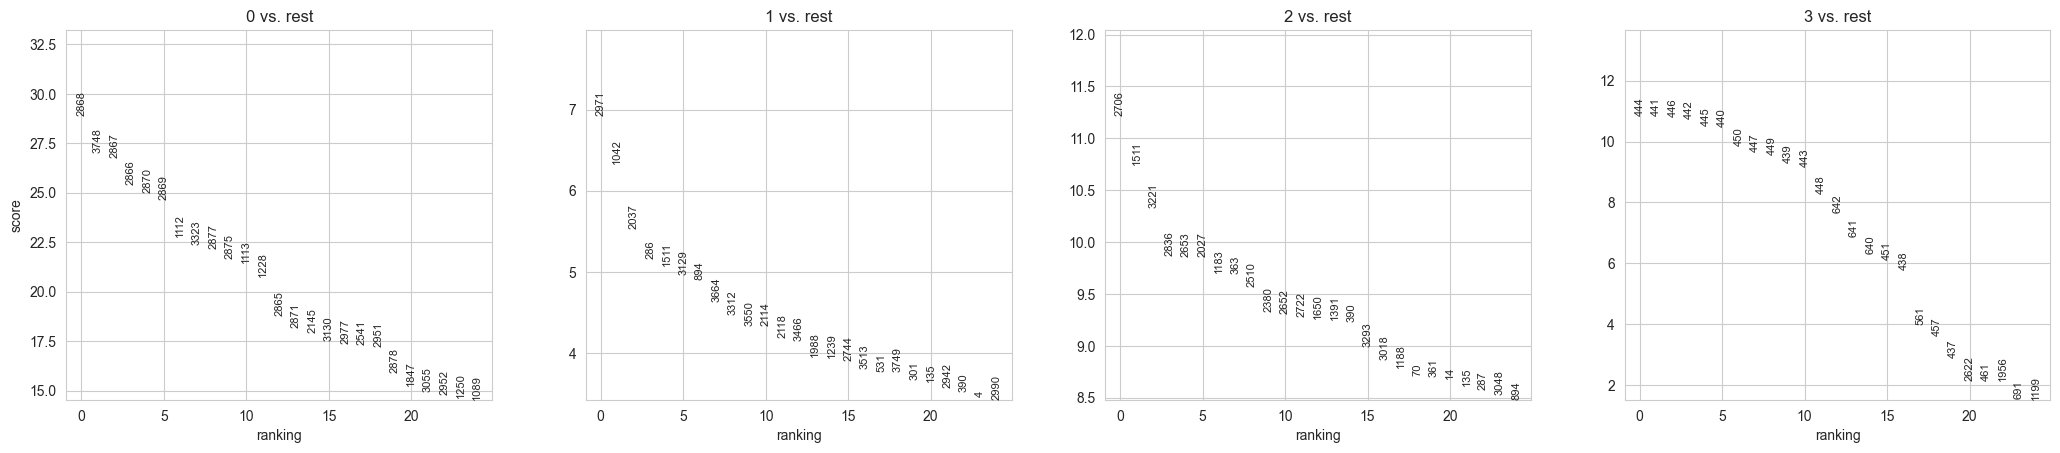

In [5]:
sc.tl.rank_genes_groups(data_export_TU, "leiden_opt", method="wilcoxon")
sc.pl.rank_genes_groups(data_export_TU, sharey=False, n_genes=25)

In [6]:
clusters = data_export_TU.obs["leiden_opt"].unique()

for c in clusters:
    p_data = pd.DataFrame(
        {"pval_data": [x[c] for x in data_export_TU.uns[f"rank_genes_groups"]["pvals"]]},
        index = [x[c] for x in data_export_TU.uns[f"rank_genes_groups"]["names"]]
    )
    data_export_TU.var[f"pval_cluster_{c}"] = p_data["pval_data"]
    
data_export_TU.var

total_counts  n_cells_by_counts  nb_overdisp_cutoff  pval_cluster_0  \
1           2471.0                970           13.072436    1.841366e-02   
2            312.0                238            3.049342    2.680651e-04   
3             62.0                 55            0.522447    2.270539e-01   
4            985.0                587            9.857914    5.575675e-09   
5             69.0                 61            0.590661    1.749186e-01   
...            ...                ...                 ...             ...   
3749        1426.0                707           12.842730    3.607459e-09   
3750           6.0                  6            0.063345    8.783385e-01   
3751         148.0                127            1.373942    1.180267e-02   
3752         636.0                466            6.573238    5.023231e-01   
3753        3862.0               1119            8.943116    1.273419e-42   

      pval_cluster_1  pval_cluster_2  pval_cluster_3  
1       1.435892e-02    8.304866e-01        0.637029  
2       8.272477e-01    3.170500e-07        0.057014  
3       5.619778e-01    2.196394e-02        0.824215  
4       5.322949e-04    9.602620e-04        0.651798  
5       9.698099e-01    7.926513e-02        0.794675  
...              ...             ...             ...  
3749    1.614846e-04    1.577786e-05        0.000805  
3750    9.123955e-01    7.297796e-01        0.957024  
3751    5.948508e-01    5.363178e-05        0.532559  
3752    1.702471e-01    4.159027e-03        0.375209  
3753    2.165061e-10    6.239392e-19        0.245455  

[3668 rows x 7 columns]

In [7]:
data_export_TU.write_h5ad("../../data/MOBA_scRNAseq/outs_S2/export_s2_TU.h5ad")